In [102]:
# !pip install  joblib==1.0.1 matplotlib==3.3.4 numpy==1.20.1 pandas==1.3.5 scikit_learn==0.24.1 scipy==1.6.2 seaborn==0.11.1 --quiet
# !pip install xgboost==1.5.1 --quiet
# !pip install featuretools==1.7.0 --quiet

In [103]:
#Importing Necessary Libraries

# Importing Data wrangling libraries
import numpy as np
import pandas as pd

# Import Statistical Libraries
from scipy import stats

# Import Feature Generation Libraries
# import featuretools as ft

# Import PLotting and Graph Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import Data Preprocessing and Modelling Libraries
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [104]:
#Imorting the datasets
train =pd.read_csv("train_kOBLwZA.csv")
test=pd.read_csv("test_t02dQwI.csv")

#Checking the shapes of train and test
print(train.shape,test.shape)

(8523, 12) (5681, 11)


In [105]:
#Defining a function
#Creating 'concat' function to concat DataFrame
def concat(X,Y):
    df= pd.concat([X,Y],ignore_index=True)
    return df

# Using concat function to concatenate train and test Data
df= concat(train,test)

# Print shape of concatenated Data Frame
print(df.shape)

(14204, 12)


In [106]:
#Print first 5 rows of Data
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [107]:
#Checks number of null values for all the variables
df.isnull().sum()

#Item_Weight has 2439 null values
#Outlet Size has 4016 null values

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [108]:
#Checks the number of unique entries correspnding to each variable
df.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
dtype: int64

In [109]:
#Defining a function
#frequency of unique entries in each columns with their names

def frequency_each_item(X,Y):
    for i in Y:
        print("frequency of each category for",i)
        print(X[i].value_counts())
        print("-"*60)

In [110]:
#Frequency of unique entries in each columns with their names
category=['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Size','Outlet_Type']
frequency_each_item(df,category)

frequency of each category for Item_Fat_Content
Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: count, dtype: int64
------------------------------------------------------------
frequency of each category for Item_Type
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: count, dtype: int64
------------------------------------------------------------
frequency of each category for Outlet_Location_Type
Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: count, dtype: int64
------

# Data Sanity Check

**General Guideline for Sanity Check**

- Check for correct data types against each columns
- Check for any unknown characters in data
- Check for duplicate data
- If you're are combining multiple data sources:
        a. joins have worked correcectly.
        b. Check no. of rows created is it acceptable.
        c. Check no. of columns created is it acceptable.

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


### Fixing Inconsistencies in "Item_Fat_Content"

In [112]:
# Correcting the mis-written datas
df['Item_Fat_Content'].replace(to_replace =['low fat','reg','LF'],
                 value =['Low Fat','Regular','Low Fat'],inplace=True)
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    9185
Regular    5019
Name: count, dtype: int64

### Fixing "Item_Visibility" with 0 values

In [113]:
# Converting all the zero values to mean in the visibility column
Item_Visibility_mean=df.groupby('Item_Identifier' )['Item_Visibility'].mean()
bool4=df['Item_Visibility']==0
df['Item_Visibility'][bool4]=df['Item_Identifier'][bool4].apply(lambda x:Item_Visibility_mean.loc[x]).values
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Handling Missing Values

**General Guideline for Treating Missing Value**

- Identify if Missing are Numerical or Categorical values.
- Check for % of missing value of a column, if more than 30% of data missing drop the column.

**For Numerical Values**:

    a. Impute with Mean, Median or constant values.
    b. Logical condition Imputation.
    c. Interpolation and Regression Approach

**For Categorical Values**

    a. Impute with Mode values
    b. Logical condition Imputation.

### Handling Missing Value for "Outlet_Size"

In [114]:
## Explantory Code
# Substitution Categorical Missing Value with Mode
# mode_value = df['Outlet_Size'].mode()[0]
# df['Outlet_Size'].fillna(mode_value)

In [115]:
# Substiutuion with Logical Condition.
mode_Outlet_Size= df.groupby(['Outlet_Type'])['Outlet_Size'].agg(pd.Series.mode)
bool2=df['Outlet_Size'].isnull()
df['Outlet_Size'][bool2] = df['Outlet_Type'][bool2].apply(lambda x : mode_Outlet_Size.loc[x]).values
sum(df['Outlet_Size'].isnull())

0

### Handling Missing Value for "Item_Weight"

In [116]:
## Explantory Code
# mean_value = df['Item_Weight'].mean()
# df['Item_Weight'].fillna(mean_value)

In [117]:
# Substiutuion with Logical Condition.
avg_item_weight=df.groupby('Item_Identifier')['Item_Weight'].agg(np.mean)
bool_value= df['Item_Weight'].isnull()
df['Item_Weight'][bool_value]=df['Item_Identifier'][bool_value].apply(lambda x :avg_item_weight.loc[x]).values
sum(df['Item_Weight'].isnull())

0

# Identifying outliers and fixing them

In [118]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,14204.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.793380,0.069710,141.004977,1997.830681,2181.288914
std,4.651716,0.049728,62.086938,8.371664,1706.499616
min,4.555000,0.003575,31.290000,1985.000000,33.290000
25%,8.710000,0.031145,94.012000,1987.000000,834.247400
50%,12.600000,0.057194,142.247000,1999.000000,1794.331000
75%,16.750000,0.096930,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


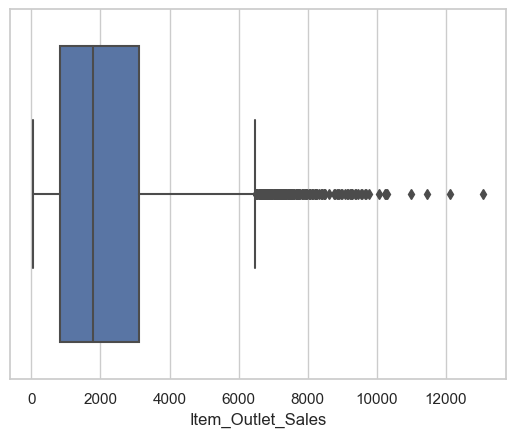

In [119]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["Item_Outlet_Sales"])

In [120]:
#As we know only Item_Outlet_Sales have outliers we can fix them but fixing them will increase our RMSE score
#to a large extent

# Handling Categorical Values

**General Guideline to treating Categorical Values**

- Identify if the variable if its Nominal or Ordinal Varriable.

- **For Nomianl Varriable:**
 Check for cardinality of the variable.
   - if cardinality = 2, you can apply:
         a. binary encoding
         b. One-hot encoding or
         c. pd.get_dummies
        
  - if cardinality < 5, you can apply:
        a. One-hot encoding or
        b. pd.get_dummies

  - if cardinality 5 - 10, you can apply:
        a. One-hot encoding or
        b. pd.get_dummies
        c. frequecny encoding
        d. target-mean encoding

  - if cardinality > 10, you can apply:
        a. if no. of categories can be reduced.
        b. frequecny encoding
        c. target-mean encoding

- **For Ordinal Varriable**: It has a defenitive order
        a. Create a dictionary for label
        b. Apply Label encoding
        c. Apply Ordinal encoding


### Handling Categorical Value "Item_Type"

In [121]:
## Explanantion Code

# df['Item_Type'].value_counts(normalize=True)*100
# # 'Item_Type' has high cardinality
# # We need to reduce the columns into fewer category if possible.
# # Can see those values which are smaller representation can be combined togther.

In [122]:
#Reducing food category to only 3 types with the help of the first 2 alphabets of the Item_Identifier column

df['Item_Type_combined']=df['Item_Identifier'].apply(lambda x : x[0:2])
df['Item_Type_combined'].replace(to_replace =['FD','DR','NC'],
                 value =['Food','Drinks','Non_consumable'],inplace=True)
#dropping the redundant column
df=df.drop(columns=['Item_Type'])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food
3,FDX07,19.20,Regular,0.017834,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food
4,NCD19,8.93,Low Fat,0.009780,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non_consumable


### Handling Categorical Value "Item_Fat_Content"


In [123]:
#Calculating number of Item_fat_contents that are also non_consumable
bool3=df['Item_Type_combined']=='Non_consumable'

df['Item_Fat_Content'][bool3]='Non_edible'
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat       6499
Regular       5019
Non_edible    2686
Name: count, dtype: int64

# Plotting Graphs for more Analysis

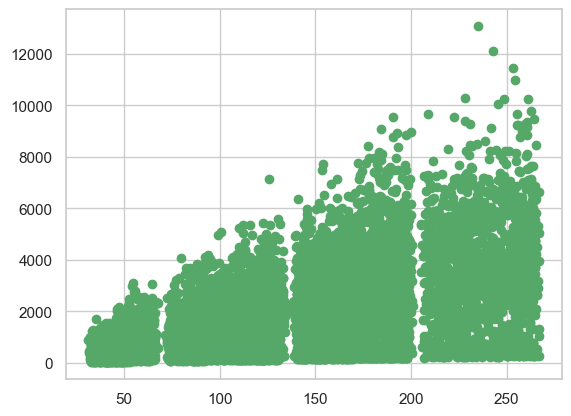

In [124]:
#value of sales increases for the increase in MRP of the item
plt.scatter(df.Item_MRP,df.Item_Outlet_Sales,c='g')
plt.show()

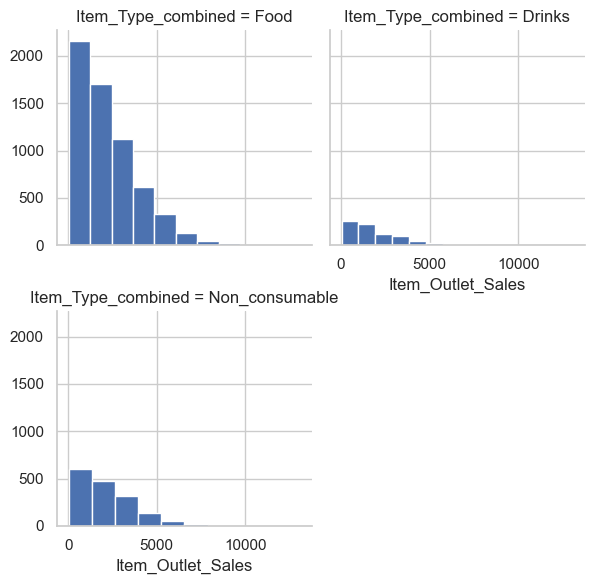

In [125]:
sns.FacetGrid(df, col='Item_Type_combined', col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
# Maximum contribution to outlet sales is from Items that are food type and least is from drinks

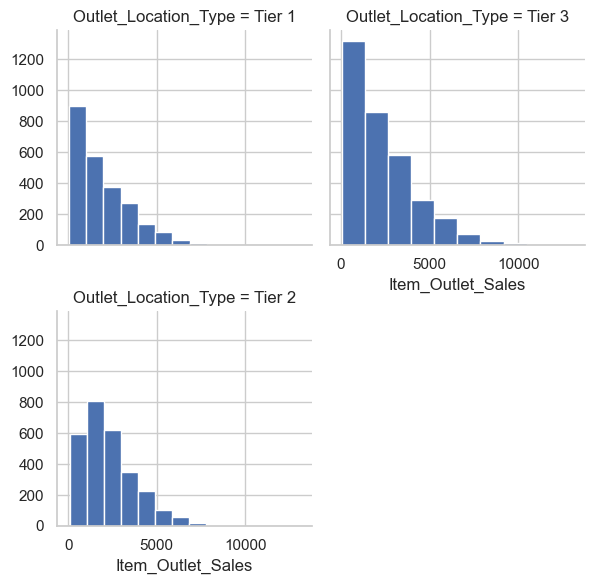

In [126]:
sns.FacetGrid(df, col='Outlet_Location_Type', col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Tier3 type of outlet location provides for the maximum sales and other two provides the least sales

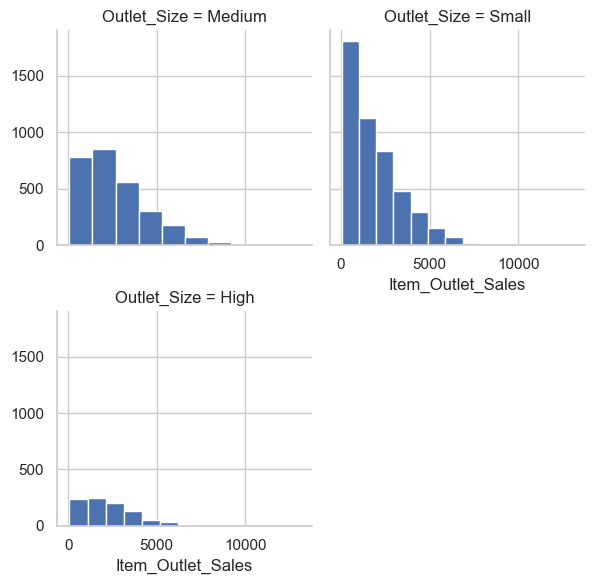

In [127]:
sns.FacetGrid(df, col='Outlet_Size', col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Small sized Outlets are providing the maximum sales whereas large sized outlets
# are contributing the least

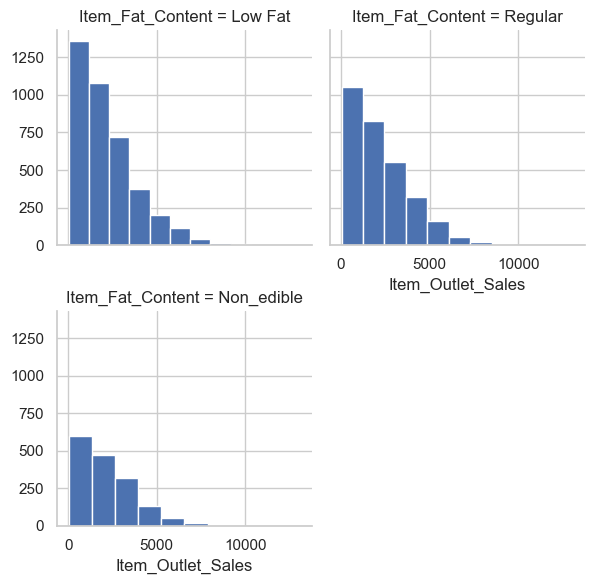

In [128]:
sns.FacetGrid(df, col='Item_Fat_Content', col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
# people are prefering items with lowest fat content the most

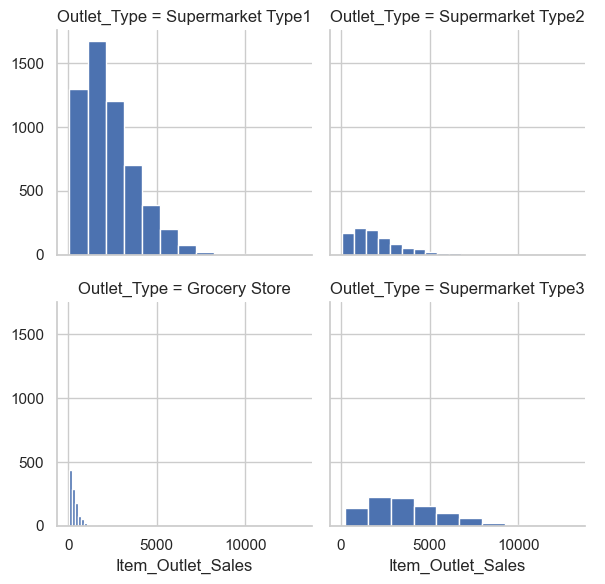

In [129]:
sns.FacetGrid(df, col='Outlet_Type', col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Maximum of the high sales margin is from Supermarket Type1
#Grocery store has the least sales

# Explanation Code
'''
Columns:
'Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_combined'

are Ordinal in Nature.

So we can either create dict or apply label encoding.

Item_Fat_Content_dict = {"Non_edible":0,
                          "Low Fat":1,
                          "Regular":2,
                          }
df['Item_Fat_Content'].apply(lambda x: Item_Fat_Content_dict[x])
or
df['Item_Fat_Content'].replace(Item_Fat_Content_dict)

OR

le=LabelEncoder()
le.fit_transform(df['Item_Fat_Content'])

le.inverse_transform([0,1,2])

'''

'''
one-hot encoding:

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit_transform('Outlet_Identifier')

pd.get_dummies:

pd.get_dummies(df_new,columns=['Outlet_Identifier'])

frequecncy Encoding:

freq_value = df.groupby('Item_Identifier').size()/len(df)
freq_dict = freq_value.to_dict()
df['Item_Identifier'].replace(freq_dict)

target Mean Encoding:

mean_value = df.groupby('Item_Identifier')['Item_Outlet_Sales'].mean()
mean_dict = mean_value.to_dict()
df['Item_Identifier'].replace(mean_dict)

'''

In [130]:
df['Outlet_Identifier'].nunique()

10

In [131]:
df['Outlet_Identifier']

0        OUT049
1        OUT018
2        OUT049
3        OUT010
4        OUT013
          ...  
14199    OUT046
14200    OUT018
14201    OUT045
14202    OUT017
14203    OUT045
Name: Outlet_Identifier, Length: 14204, dtype: object

In [132]:
# one-hot encoding:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
outlet_array = enc.fit_transform(df[['Outlet_Identifier']]).toarray()
outlet_array

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [133]:
outlet_array[3]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [134]:
enc.categories_

[array(['OUT010', 'OUT013', 'OUT017', 'OUT018', 'OUT019', 'OUT027',
        'OUT035', 'OUT045', 'OUT046', 'OUT049'], dtype=object)]

In [135]:
enc

OneHotEncoder()

In [136]:
df_enc = pd.DataFrame(outlet_array,columns=enc.categories_)
df_enc

,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
14199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14200,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
pd.merge(df,df_enc,how='left',left_index=True,right_index=True).head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,...,"(OUT010,)","(OUT013,)","(OUT017,)","(OUT018,)","(OUT019,)","(OUT027,)","(OUT035,)","(OUT045,)","(OUT046,)","(OUT049,)"
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,FDX07,19.20,Regular,0.017834,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,8.93,Non_edible,0.009780,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
pd.concat([df,df_enc],axis=1).head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,...,"(OUT010,)","(OUT013,)","(OUT017,)","(OUT018,)","(OUT019,)","(OUT027,)","(OUT035,)","(OUT045,)","(OUT046,)","(OUT049,)"
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,FDX07,19.20,Regular,0.017834,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,8.93,Non_edible,0.009780,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
# pd.get_dummies:
pd.get_dummies(df,columns=['Outlet_Identifier']).iloc[:,-10::].head()

,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,False,False,False,False,False,False,False,False,False,True
1,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False


In [140]:
# frequecncy Encoding:

freq_value = df.groupby('Outlet_Identifier').size()/len(df)
freq_value = df['Outlet_Identifier'].value_counts(normalize=True)
freq_dict = freq_value.to_dict()
df['Outlet_Identifier'].replace(freq_dict)

0        0.109124
1        0.108843
2        0.109124
3        0.065123
4        0.109335
           ...   
14199    0.109124
14200    0.108843
14201    0.108983
14202    0.108631
14203    0.108983
Name: Outlet_Identifier, Length: 14204, dtype: float64

In [141]:
df['Outlet_Identifier'].value_counts(normalize=True)

Outlet_Identifier
OUT027    0.109758
OUT013    0.109335
OUT049    0.109124
OUT046    0.109124
OUT035    0.109124
OUT045    0.108983
OUT018    0.108843
OUT017    0.108631
OUT010    0.065123
OUT019    0.061954
Name: proportion, dtype: float64

In [142]:
df['Outlet_Identifier'].value_counts(normalize=True).to_dict()

{'OUT027': 0.10975781470008449,
 'OUT013': 0.1093353984793016,
 'OUT049': 0.10912419036891016,
 'OUT046': 0.10912419036891016,
 'OUT035': 0.10912419036891016,
 'OUT045': 0.10898338496198254,
 'OUT018': 0.10884257955505491,
 'OUT017': 0.10863137144466348,
 'OUT010': 0.06512250070402703,
 'OUT019': 0.06195437904815545}

In [143]:
df['Outlet_Identifier'].replace(freq_dict)

0        0.109124
1        0.108843
2        0.109124
3        0.065123
4        0.109335
           ...   
14199    0.109124
14200    0.108843
14201    0.108983
14202    0.108631
14203    0.108983
Name: Outlet_Identifier, Length: 14204, dtype: float64

In [144]:
freq_value = df.groupby('Item_Identifier').size()/len(df)
print(freq_value)
freq_dict = freq_value.to_dict()
print(freq_dict)
df['Item_Identifier'].replace(freq_dict)

Item_Identifier
DRA12    0.000634
DRA24    0.000704
DRA59    0.000704
DRB01    0.000563
DRB13    0.000634
           ...   
NCZ30    0.000704
NCZ41    0.000563
NCZ42    0.000704
NCZ53    0.000634
NCZ54    0.000704
Length: 1559, dtype: float64
{'DRA12': 0.0006336243311743171, 'DRA24': 0.0007040270346381301, 'DRA59': 0.0007040270346381301, 'DRB01': 0.000563221627710504, 'DRB13': 0.0006336243311743171, 'DRB24': 0.000563221627710504, 'DRB25': 0.0007040270346381301, 'DRB48': 0.0006336243311743171, 'DRC01': 0.0006336243311743171, 'DRC12': 0.000563221627710504, 'DRC13': 0.000563221627710504, 'DRC24': 0.0006336243311743171, 'DRC25': 0.0007040270346381301, 'DRC27': 0.0007040270346381301, 'DRC36': 0.0007040270346381301, 'DRC49': 0.0006336243311743171, 'DRD01': 0.0006336243311743171, 'DRD12': 0.000563221627710504, 'DRD13': 0.000563221627710504, 'DRD15': 0.0007040270346381301, 'DRD24': 0.0007040270346381301, 'DRD25': 0.0007040270346381301, 'DRD27': 0.0006336243311743171, 'DRD37': 0.000633624331174

0        0.000634
1        0.000634
2        0.000704
3        0.000634
4        0.000634
           ...   
14199    0.000704
14200    0.000704
14201    0.000634
14202    0.000704
14203    0.000634
Name: Item_Identifier, Length: 14204, dtype: float64

In [145]:
# target Mean Encoding:

mean_value = df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean()
print(mean_value)
mean_dict = mean_value.to_dict()
print(mean_dict)
df['Outlet_Identifier'].replace(mean_dict)

Outlet_Identifier
OUT010     339.351662
OUT013    2298.995256
OUT017    2340.675263
OUT018    1995.498739
OUT019     340.329723
OUT027    3694.038558
OUT035    2438.841866
OUT045    2192.384798
OUT046    2277.844267
OUT049    2348.354635
Name: Item_Outlet_Sales, dtype: float64
{'OUT010': 339.351661981982, 'OUT013': 2298.995255579399, 'OUT017': 2340.67526349892, 'OUT018': 1995.498739224138, 'OUT019': 340.3297227272727, 'OUT027': 3694.0385576470585, 'OUT035': 2438.841866021505, 'OUT045': 2192.384797631862, 'OUT046': 2277.8442668817206, 'OUT049': 2348.3546346236562}


0        2348.354635
1        1995.498739
2        2348.354635
3         339.351662
4        2298.995256
            ...     
14199    2277.844267
14200    1995.498739
14201    2192.384798
14202    2340.675263
14203    2192.384798
Name: Outlet_Identifier, Length: 14204, dtype: float64

In [146]:
df['Item_Fat_Content']

0           Low Fat
1           Regular
2           Low Fat
3           Regular
4        Non_edible
            ...    
14199       Regular
14200       Regular
14201    Non_edible
14202       Regular
14203       Regular
Name: Item_Fat_Content, Length: 14204, dtype: object

In [147]:
Item_Fat_Content_dict = {"Non_edible":0,
                          "Low Fat":1,
                          "Regular":2,
                          }

# df['Item_Fat_Content'].apply(lambda x: Item_Fat_Content_dict[x])
df['Item_Fat_Content'].replace(Item_Fat_Content_dict)

0        1
1        2
2        1
3        2
4        0
        ..
14199    2
14200    2
14201    0
14202    2
14203    2
Name: Item_Fat_Content, Length: 14204, dtype: int64

In [148]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit_transform(df['Item_Fat_Content'])

array([0, 2, 0, ..., 1, 2, 2])

In [149]:
le.inverse_transform([0,1,2])

array(['Low Fat', 'Non_edible', 'Regular'], dtype=object)

In [150]:
from sklearn.preprocessing import OrdinalEncoder
Oe= OrdinalEncoder()
Oe.fit_transform(df[['Item_Fat_Content']])

array([[0.],
       [2.],
       [0.],
       ...,
       [1.],
       [2.],
       [2.]])

In [151]:
Oe.inverse_transform([[0],[1],[2]])

array([['Low Fat'],
       ['Non_edible'],
       ['Regular']], dtype=object)

In [152]:
#Label Encoding all the columns with text entries and dropping Item_identifier
list=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_combined',
      'Outlet_Size']

le=LabelEncoder()
for i in list:
    df[i]= le.fit_transform(df[i])
# or
# Oe = OrdinalEncoder()
# Oe.fit_transform(df[list])


df_new=df.drop(columns='Item_Identifier')  # frequency encoding
df_new= pd.get_dummies(df_new,columns=['Outlet_Identifier'])
df_new.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,1999,1,0,1,3735.1380,1,False,False,False,False,False,False,False,False,False,True
1,5.92,2,0.019278,48.2692,2009,1,2,2,443.4228,0,False,False,False,True,False,False,False,False,False,False
2,17.50,0,0.016760,141.6180,1999,1,0,1,2097.2700,1,False,False,False,False,False,False,False,False,False,True
3,19.20,2,0.017834,182.0950,1998,2,2,0,732.3800,1,True,False,False,False,False,False,False,False,False,False
4,8.93,1,0.009780,53.8614,1987,0,2,1,994.7052,2,False,True,False,False,False,False,False,False,False,False


# Feature Engineering

In [153]:
#Using feature Engineering and adding new column
df_new['years_old']=2023-df_new['Outlet_Establishment_Year']
df_new=df_new.drop(columns=['Outlet_Establishment_Year'])
df_new.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,years_old
0,9.30,0,0.016047,249.8092,1,0,1,3735.1380,1,False,False,False,False,False,False,False,False,False,True,24
1,5.92,2,0.019278,48.2692,1,2,2,443.4228,0,False,False,False,True,False,False,False,False,False,False,14
2,17.50,0,0.016760,141.6180,1,0,1,2097.2700,1,False,False,False,False,False,False,False,False,False,True,24
3,19.20,2,0.017834,182.0950,2,2,0,732.3800,1,True,False,False,False,False,False,False,False,False,False,25
4,8.93,1,0.009780,53.8614,0,2,1,994.7052,2,False,True,False,False,False,False,False,False,False,False,36


### Checking correlation for all Numerical Variable

In [154]:
# explanatory code

<Axes: >

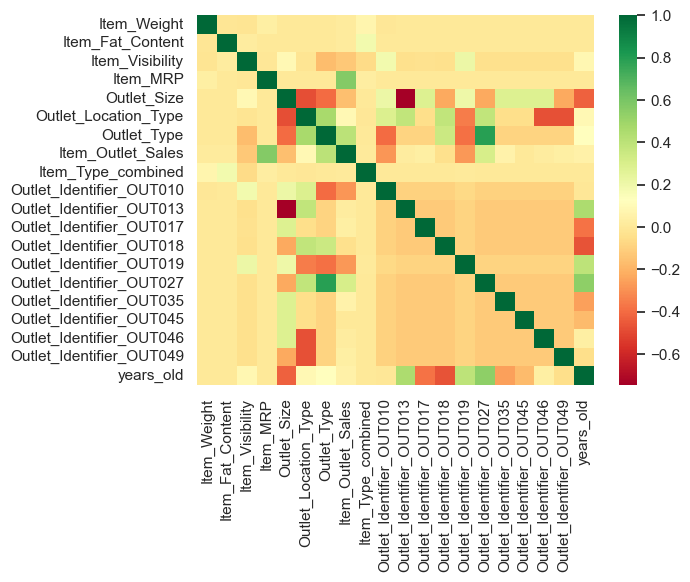

In [155]:
df_new.corr()
sns.heatmap(df_new.corr(),cmap='RdYlGn')

# Creating Test and Train set

In [156]:
#Separating test and train set
df_train=df_new.iloc[:8523,:]
df_test=df_new.iloc[8523:,:]

df_test=df_test.drop(columns=['Item_Outlet_Sales'])

In [157]:
#Splitting X (independent factor) and Y (target factor)
y = df_train['Item_Outlet_Sales']

X = df_train.drop(columns=['Item_Outlet_Sales'])

In [158]:
X.shape

(8523, 19)

In [159]:
X.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Type_combined', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'years_old'],
      dtype='object')

In [160]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# Defining my final model that I will use for prediction
model.fit(X,y)
model.predict(X)

array([4043.06508605,  604.21120294, 2359.35690095, ..., 1521.58464772,
       1408.16690788, 1251.74458312])

### Evaluation

In [161]:
# Metrics Calculation
from sklearn.metrics import r2_score, mean_absolute_error ,mean_squared_error

import math
def root_mean_squared_error(y,y_pred):
    mse =np.square(np.subtract(y,y_pred)).mean()
    rmse = math.sqrt(mse)
    return rmse

model.intercept_ , model.coef_

print("MAE Score for model is : ",mean_absolute_error(y,model.predict(X)))
print("MSE Score for model is : ",mean_squared_error(y,model.predict(X)))
print("RMSE Score for model is : ",root_mean_squared_error(y,model.predict(X)))
print("R2 Score for model is : ",r2_score(y,model.predict(X)))

MAE Score for model is :  836.0930013571033
MSE Score for model is :  1271264.8598822241
RMSE Score for model is :  1127.5038181231246
R2 Score for model is :  0.563409168304077


# Improvement and Enchancement of Model

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor

#### To Be applied after we cover these Algorithms.
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import BaggingRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.neural_network import MLPRegressor
# from xgboost import XGBRegressor
# import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


In [163]:
models = [('lr',LinearRegression()),
          ('sgd',SGDRegressor()),
          ('lasso',Lasso()),
          ('ridge',Ridge()),
          ('en',ElasticNet()),
          ('huber',HuberRegressor()),
          ('ransac',RANSACRegressor()),
          ('theilSen',TheilSenRegressor())
         ]

In [164]:
import sklearn
sklearn.metrics.get_scorer_names()

# For evaluating multiple scores, use sklearn.model_selection.cross_validate instead. ['r2'] was passed.


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [165]:
#Making function for making best 2 models for further hyperparameter tuning
#  https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
def basic_model_selection(x,y,cross_folds,model,scoring):
    scores=[]
    names = []
    for i , j in model:
        cv_scores = cross_val_score(j, x, y,cv=cross_folds,n_jobs=5,scoring=scoring)
        scores.append(cv_scores)
        names.append(i)
    for k in range(len(scores)):
        print(names[k],scores[k].mean())

In [166]:
basic_model_selection(X,y,4,models,'r2')

lr 0.5600167514366816
sgd -5.904493848389208e+18
lasso 0.5600381393243655
ridge 0.5600211200777784
en 0.4778294429615873
huber 0.5541310416712488
ransac 0.48995415090759725
theilSen 0.5510316632721883


In [167]:
# N Mae score
basic_model_selection(X,y,4,models,'neg_mean_absolute_error')

lr -838.6430244950401
sgd -2988908507491.112
lasso -838.2323416178793
ridge -838.6018592402061
en -910.6618386560157
huber -831.497691789984
ransac -897.9406436940151
theilSen -843.1367137315015



'''
Way to understand neg_mean_absolute_error (NMAE).
The way in which neg_mean_absolute_error is computed as follows:
![](https://i.stack.imgur.com/39XDd.gif)

where N is the total number of data points, Y_i is the true value and Y_i^p is the predicted value.

Still we equally penalize the model if it predicts higher or lower than the true value, but it is just that we multiply the final result with -1 just to follow the convention that sklearn has set. So if a model gives you a MAE of say 0.55 and another model gives you a MAE of say 0.78, their NMAE values would be flipped as -0.55 and -0.78 and by following the convention of higher the better, we pick the former model which results has a higher NMAE of -0.55.

It's simple: minimizing MSE is equivalent to maximizing negative-MSE.

An objective function that the scorer can maximize is just by "convention" as the Sklearn documentation suggests.

You can make a similar argument for MSE.
'''

In [168]:
# N Mse score
basic_model_selection(X,y,4,models,'neg_mean_squared_error')

lr -1278990.753409691
sgd -4.578736225338852e+25
lasso -1278928.173405622
ridge -1278979.4368474921
en -1519096.4019700158
huber -1297046.2285731598
ransac -1647571.9856848698
theilSen -1302025.8124072182


In [169]:
# R2 score
basic_model_selection(X,y,4,models,'neg_mean_absolute_percentage_error')

lr -1.0361393620915051
sgd -1400491681.776033
lasso -1.031310689075672
ridge -1.0356841899611444
en -1.0169575038111296
huber -0.9653046636010818
ransac -1.0203679635785294
theilSen -0.9617926527965657


# Standardization of the model before training

In [170]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

standardized=scaler.fit_transform(X)
column_names = X.columns
df_standardized = pd.DataFrame(data=standardized,columns=column_names)
df_standardized.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,years_old
0,-0.769246,-0.997813,-1.081039,1.747454,-0.664080,-1.369334,-0.252658,-0.179795,-0.263920,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,2.857362,-0.139541
1,-1.496813,1.236942,-1.016230,-1.489023,-0.664080,1.091569,1.002972,-2.095286,-0.263920,-0.350395,-0.349128,2.860816,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973,-1.334103
2,0.995858,-0.997813,-1.066741,0.010040,-0.664080,-1.369334,-0.252658,-0.179795,-0.263920,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,2.857362,-0.139541
3,1.361794,1.236942,-1.045193,0.660050,0.799954,1.091569,-1.508289,-0.179795,3.789031,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973,-0.020085
4,-0.848890,0.119565,-1.206757,-1.399220,-2.128115,1.091569,-0.252658,1.735696,-0.263920,2.853918,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973,1.293934


In [171]:
basic_model_selection(df_standardized,y,4,models,'r2')

lr 0.560046857100979
sgd 0.5595515299769793
lasso 0.5600956145231253
ridge 0.5600174793091026
en 0.5116677899683771
huber 0.5540855379255999
ransac 0.48683524454038846
theilSen 0.5238613785820169


# Using Robust Scaler

#### My dataset having outliers make it more prone to mistakes
* Robust Scaler handles the outliers as well
* It scales according to the quartile range

In [172]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

normalize = MinMaxScaler()
robust = RobustScaler(quantile_range = (0.1,0.8)) #range of inerquartile is one of the parameters

robust_stan = robust.fit_transform(X)
robust_stan_normalize = normalize.fit_transform(robust_stan)

# also normalized the dataset using MinMaxScaler i.e has bought the data set between (0,1)
df_robust_normalize = pd.DataFrame(robust_stan_normalize,columns=column_names)
df_robust_normalize.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,years_old
0,0.282525,0.0,0.038399,0.927507,0.5,0.0,0.333333,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.416667
1,0.081274,1.0,0.048346,0.072068,0.5,1.0,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.770765,0.0,0.040593,0.468288,0.5,0.0,0.333333,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.416667
3,0.871986,1.0,0.043901,0.640093,1.0,1.0,0.000000,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.458333
4,0.260494,0.5,0.019104,0.095805,0.0,1.0,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916667


In [173]:
basic_model_selection(df_robust_normalize,y,4,models,'r2')

lr 0.5599808781314108
sgd 0.5596105284773998
lasso 0.5602364376089488
ridge 0.5600244473901529
en 0.16451784419804824
huber 0.5540659349001216
ransac 0.38796025831408804
theilSen 0.5466672318791168


# Best Model
#### Comparing all models using RMSE score

In [174]:
robust_test = robust.fit_transform(X)
robust_normalize_test = normalize.fit_transform(robust_test)
df_test_robust_normalize = pd.DataFrame(robust_normalize_test,columns=column_names)

In [175]:
model = LinearRegression()
# Defining my final model that I will use for prediction

In [176]:
# Metrics Calculation
from sklearn.metrics import r2_score, mean_absolute_error ,mean_squared_error

import math
def root_mean_squared_error(y,y_pred):
    mse =np.square(np.subtract(y,y_pred)).mean()
    rmse = math.sqrt(mse)
    return rmse

In [177]:
model.intercept_ , model.coef_

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

In [ ]:
print("MAE Score for model is : ",mean_absolute_error(y,model.predict(df_robust_normalize)))
print("MSE Score for model is : ",mean_squared_error(y,model.predict(df_robust_normalize)))
print("RMSE Score for model is : ",root_mean_squared_error(y,model.predict(df_robust_normalize)))
print("R2 Score for model is : ",r2_score(y,model.predict(df_robust_normalize)))

In [ ]:
final_prediction=model.predict(df_test_robust_normalize) #Predicting the outlet sales

In [ ]:
#the prediction is in the form of numpy array
# Converting into Dataframe
df_final_prediction = pd.DataFrame(final_prediction,columns=['Item_Outlet_Sales'])

In [ ]:
df_final_prediction.head()

# Saving the final model using Joblib

In [ ]:
import joblib
filename = 'linear_regression.joblib' # Name of the model
joblib.dump(model, filename) # it is saved in your current working directory

In [ ]:
# This command loads the model once again
load_model = joblib.load(filename)

In [ ]:
float_formatter = "{:.2f}".format

In [ ]:
load_model.predict(np.array(df_robust_normalize.iloc[0,:]).reshape(1, -1))

In [ ]:
load_model.predict(np.array(df_robust_normalize.iloc[0:5,:]))

# The Models for hyperparameter tuning are same Regression Models

In [ ]:
def model_parameter_tuning(x,y,model,parameters,cross_folds):
    model_grid = GridSearchCV(model,
                        parameters,
                        cv = cross_folds,
                        n_jobs = 5,
                        verbose=True)
    model_grid.fit(x,y)
    y_predicted = model_grid.predict(x)
    print(model_grid.score)
    print(model_grid.best_params_)
    print("The RMSE score is",np.sqrt(np.mean((y-y_predicted)**2)))
    print("The R2 score is",r2_score(y,y_predicted))

#defining function for hyper parameter tuning and using RMSE as my metric
model = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

model_parameters=[{"alpha": alphas}]

model_parameter_tuning(df_standardized,y,model,model_parameters,4)

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor


# Create a Random Forest Regressor with 100 trees
n_trees = 100
random_forest = RandomForestRegressor(n_estimators=n_trees, random_state=42)

# Train the Random Forest Regressor
random_forest.fit(df_standardized, y)


print("MAE Score for model is : ",mean_absolute_error(y,random_forest.predict(df_standardized)))
print("MSE Score for model is : ",mean_squared_error(y,random_forest.predict(df_standardized)))
print("RMSE Score for model is : ",root_mean_squared_error(y,random_forest.predict(df_standardized)))
print("R2 Score for model is : ",r2_score(y,random_forest.predict(df_standardized)))

# **XG Boost**

In [ ]:
import xgboost as xgb

# Create an XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the regressor
xgb_regressor.fit(df_standardized, y)

print("MAE Score for model is : ",mean_absolute_error(y,xgb_regressor.predict(df_standardized)))
print("MSE Score for model is : ",mean_squared_error(y,xgb_regressor.predict(df_standardized)))
print("RMSE Score for model is : ",root_mean_squared_error(y,xgb_regressor.predict(df_standardized)))
print("R2 Score for model is : ",r2_score(y,xgb_regressor.predict(df_standardized)))

# **Light GBM**

In [ ]:
import lightgbm as lgb


# Create a LightGBM Regressor
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the regressor
lgb_regressor.fit(df_standardized, y)

print("MAE Score for model is : ",mean_absolute_error(y,lgb_regressor.predict(df_standardized)))
print("MSE Score for model is : ",mean_squared_error(y,lgb_regressor.predict(df_standardized)))
print("RMSE Score for model is : ",root_mean_squared_error(y,lgb_regressor.predict(df_standardized)))
print("R2 Score for model is : ",r2_score(y,lgb_regressor.predict(df_standardized)))

# **Cat Boost**

In [ ]:
! pip install catboost --quiet

In [ ]:
from catboost import CatBoostRegressor, Pool


# Create a CatBoost Regressor
catboost_regressor = CatBoostRegressor(iterations=100, learning_rate=0.1, random_state=42)

# Train the regressor
catboost_regressor.fit(df_standardized, y)

print("MAE Score for model is : ",mean_absolute_error(y,catboost_regressor.predict(df_standardized)))
print("MSE Score for model is : ",mean_squared_error(y,catboost_regressor.predict(df_standardized)))
print("RMSE Score for model is : ",root_mean_squared_error(y,catboost_regressor.predict(df_standardized)))
print("R2 Score for model is : ",r2_score(y,catboost_regressor.predict(df_standardized)))